In [1]:
!pip install blitz-bayesian-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.4 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [4]:
start = -7
end = 7
n = 300
batch_size = 16

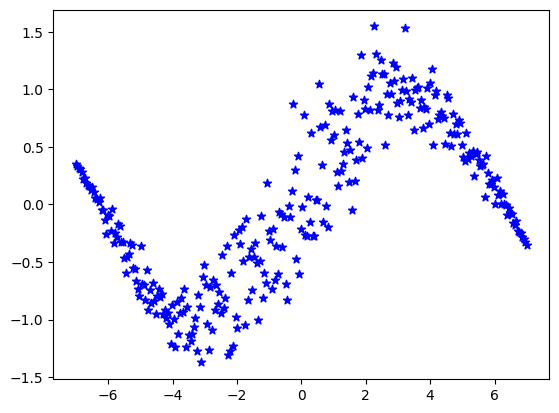

In [5]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

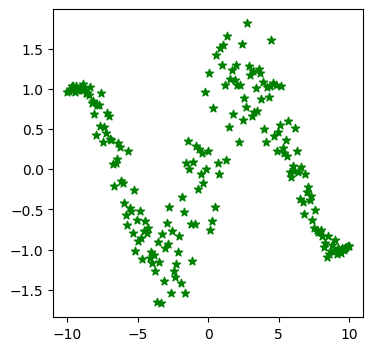

In [6]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

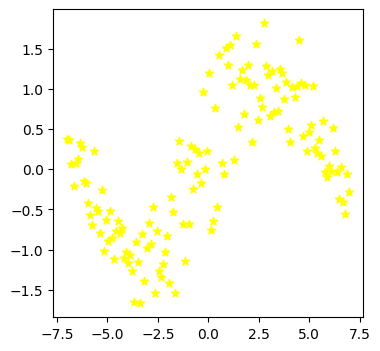

In [7]:
#Plotting In Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask =  (x_test >= -7) &  (x_test <= 7) # Select the ranges -10 to -7 and 7 to 10
x_test_idd = x_test[mask]
y_test_idd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_idd, y_test_idd, c="yellow", marker="*")

plt.show()


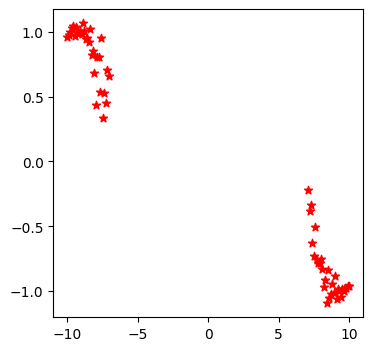

In [8]:
#Plotting Out of Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask = (x_test >= -10) & (x_test < -7) | (x_test > 7) & (x_test <= 10) # Select the ranges -10 to -7 and 7 to 10
x_test_oodd = x_test[mask]
y_test_oodd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_oodd, y_test_oodd, c="red", marker="*")

plt.show()


In [9]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Test for OODD (Out of Data Distribution)
tensor_x_test_oodd = torch.Tensor(x_test_oodd).unsqueeze(1)
tensor_y_test_oodd = torch.Tensor(y_test_oodd).unsqueeze(1)
test_dataset_oodd = TensorDataset(tensor_x_test_oodd, tensor_y_test_oodd)
test_loader_oodd = DataLoader(test_dataset_oodd, batch_size=batch_size, shuffle=True)

#Test for IDD (In Data Distribution)
tensor_x_test_idd = torch.Tensor(x_test_idd).unsqueeze(1)
tensor_y_test_idd = torch.Tensor(y_test_idd).unsqueeze(1)
test_dataset_idd = TensorDataset(tensor_x_test_idd, tensor_y_test_idd)
test_loader_idd = DataLoader(test_dataset_idd, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [10]:


@variational_estimator
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_size = 29

        self.blinear1 = BayesianLinear(1, hidden_size, prior_sigma_1=1)
        self.blinear2 = BayesianLinear(hidden_size, hidden_size, prior_sigma_1=1)
        self.blinear3 = BayesianLinear(hidden_size, 1, prior_sigma_1=1)

    def forward(self, x):
        x_ = torch.relu(self.blinear1(x))
        x_ = torch.relu(self.blinear2(x_))
        return self.blinear3(x_)



In [11]:
def make_plot_bnn(model, samples = 500):
    preds = [model(tensor_x_test) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.1)

    plt.show()

In [12]:
def make_plot_bnn_oodd(model, samples = 500):
    preds = [model(tensor_x_test_oodd) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test_oodd.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_test_oodd, y_test_oodd, c="red", marker="*", alpha=0.1)

    plt.show()

In [13]:
def make_plot_bnn_idd(model, samples = 500):
    preds = [model(tensor_x_test_idd) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test_idd.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_test_idd, y_test_idd, c="yellow", marker="*", alpha=0.1)

    plt.show()

In [14]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.MSELoss()
bnn = BayesianNetwork()
print(bnn)
print("Params:", sum(p.numel() for p in bnn.parameters() if p.requires_grad))
bnn.train()
bnn.to(device)
optimizer = optim.Adam(bnn.parameters(), lr=0.01)


BayesianNetwork(
  (blinear1): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (blinear2): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (blinear3): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
)
Params: 3832


In [15]:
def MLE_bnn():
  bnn=BayesianNetwork()
  criterion =torch.nn.MSELoss()
  optimizer = optim.Adam(bnn.parameters(), lr=0.001)
  bnn.train()
  bnn.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()

        # See https://arxiv.org/pdf/1505.05424.pdf for complexity cost weight
        loss = bnn.sample_elbo(inputs=x,
                           labels=y,
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=0.01/len(train_dataset))

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        all_test_losses = []

        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             loss = bnn.sample_elbo(inputs=x,
                           labels=y,
                           criterion=criterion,
                           sample_nbr=3,
                           complexity_cost_weight=0.01/len(test_dataset))
             all_test_losses.append(loss.item())


        test_loss = sum(all_test_losses)/len(all_test_losses)


  make_plot_bnn(bnn)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")

  return loss, test_loss


In [16]:
def MLE_bnn_oodd():
  bnn=BayesianNetwork()
  criterion =torch.nn.MSELoss()
  optimizer = optim.Adam(bnn.parameters(), lr=0.001)
  bnn.train()
  bnn.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()

        # See https://arxiv.org/pdf/1505.05424.pdf for complexity cost weight
        loss = bnn.sample_elbo(inputs=x,
                           labels=y,
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=0.01/len(train_dataset))

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        all_test_losses = []

        # Test loop
        for batch in test_loader_oodd:
             x = batch[0].to(device)
             y = batch[1].to(device)
             loss = bnn.sample_elbo(inputs=x,
                           labels=y,
                           criterion=criterion,
                           sample_nbr=3,
                           complexity_cost_weight=0.01/len(test_dataset))
             all_test_losses.append(loss.item())


        test_loss = sum(all_test_losses)/len(all_test_losses)


  make_plot_bnn_oodd(bnn)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")

  return loss, test_loss


In [17]:
def MLE_bnn_idd():
  bnn=BayesianNetwork()
  criterion =torch.nn.MSELoss()
  optimizer = optim.Adam(bnn.parameters(), lr=0.001)
  bnn.train()
  bnn.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()

        # See https://arxiv.org/pdf/1505.05424.pdf for complexity cost weight
        loss = bnn.sample_elbo(inputs=x,
                           labels=y,
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=0.01/len(train_dataset))

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        all_test_losses = []

        # Test loop
        for batch in test_loader_idd:
             x = batch[0].to(device)
             y = batch[1].to(device)
             loss = bnn.sample_elbo(inputs=x,
                           labels=y,
                           criterion=criterion,
                           sample_nbr=3,
                           complexity_cost_weight=0.01/len(test_dataset))
             all_test_losses.append(loss.item())


        test_loss = sum(all_test_losses)/len(all_test_losses)


  make_plot_bnn_idd(bnn)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")

  return loss, test_loss


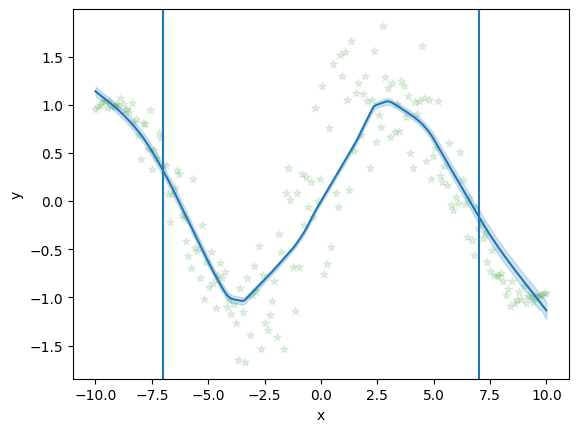

Epoch 149 | batch train loss: 0.1865803748369217 | test loss: 0.3474599581498366


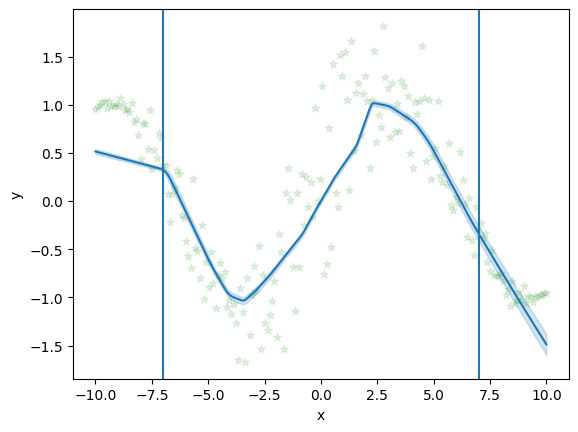

Epoch 149 | batch train loss: 0.14021232724189758 | test loss: 0.3782861324457022


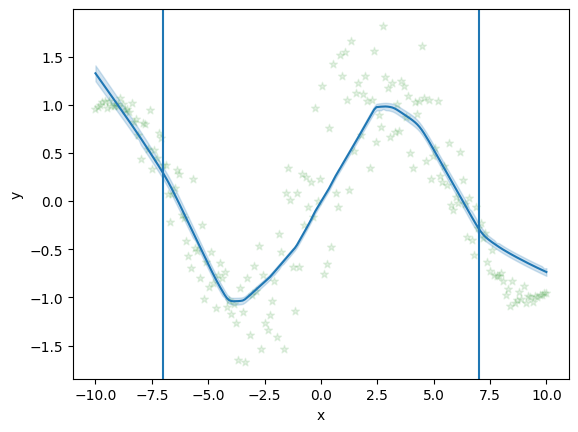

Epoch 149 | batch train loss: 0.1719384342432022 | test loss: 0.3568211106153635


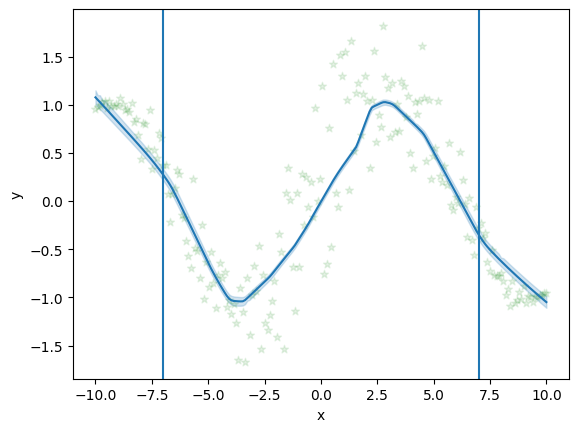

Epoch 149 | batch train loss: 0.19327117502689362 | test loss: 0.35157581246816194


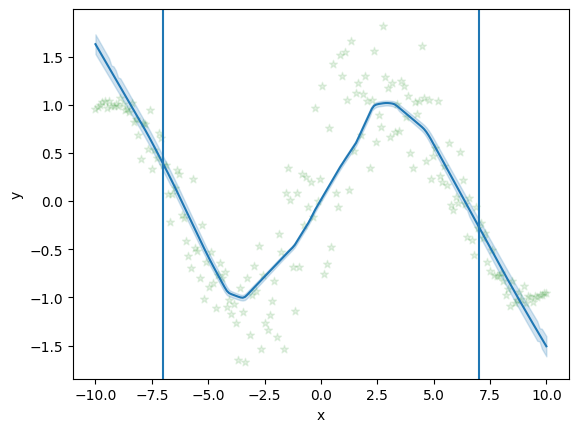

Epoch 149 | batch train loss: 0.17165222764015198 | test loss: 0.36883727403787464


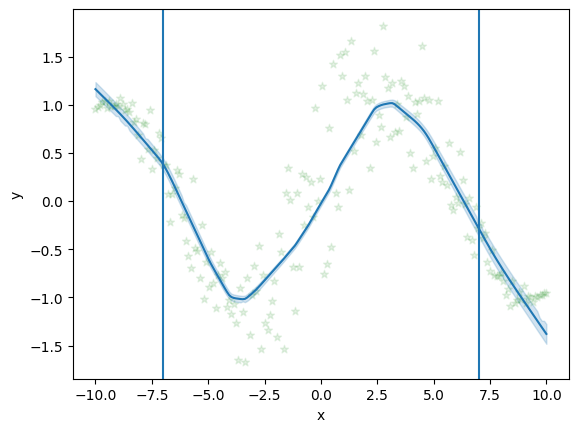

Epoch 149 | batch train loss: 0.18912921845912933 | test loss: 0.3486392773114718


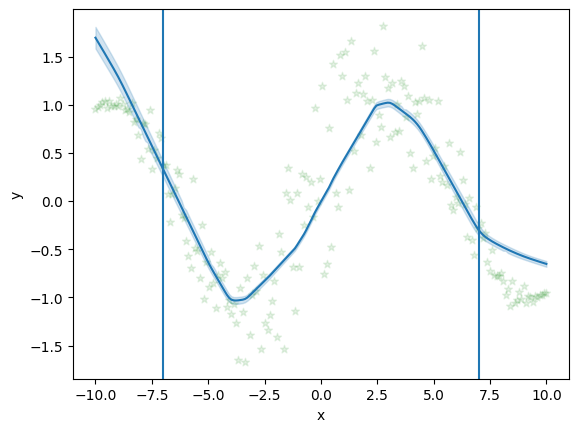

Epoch 149 | batch train loss: 0.2373109757900238 | test loss: 0.38080639334825367


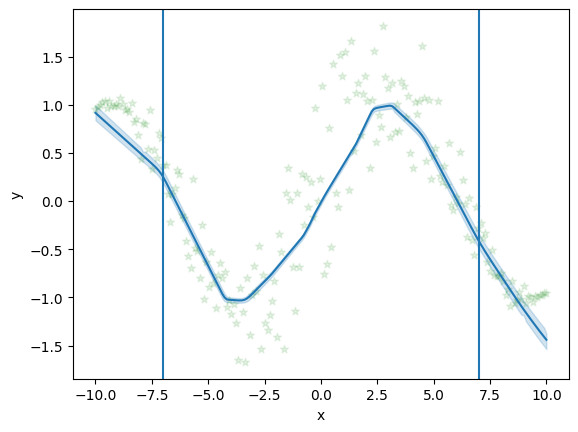

Epoch 149 | batch train loss: 0.24029026925563812 | test loss: 0.35185365264232343


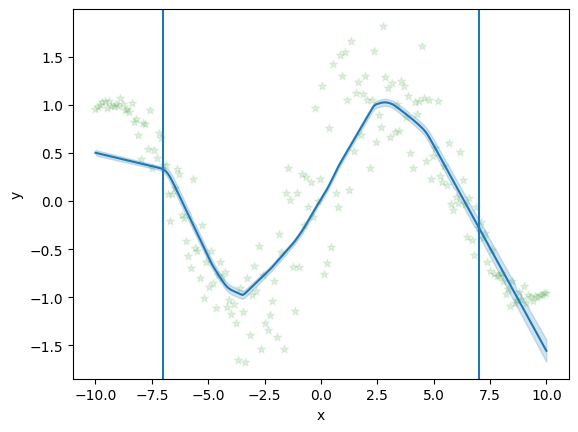

Epoch 149 | batch train loss: 0.16465863585472107 | test loss: 0.37995388874640834


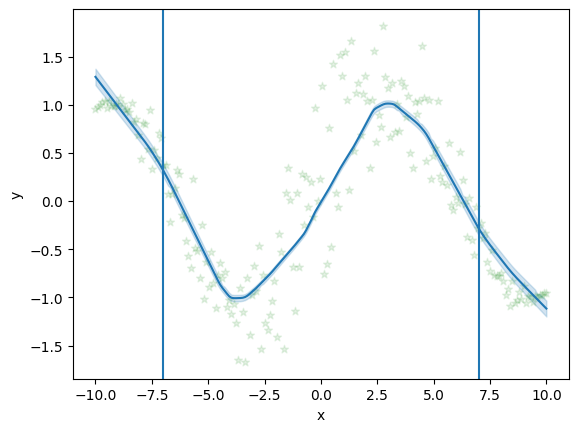

Epoch 149 | batch train loss: 0.27524858713150024 | test loss: 0.3471794082568242


In [18]:
train_losses=[]
test_losses=[]

for i in range(10):
  tr_loss,test_loss = MLE_bnn()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)


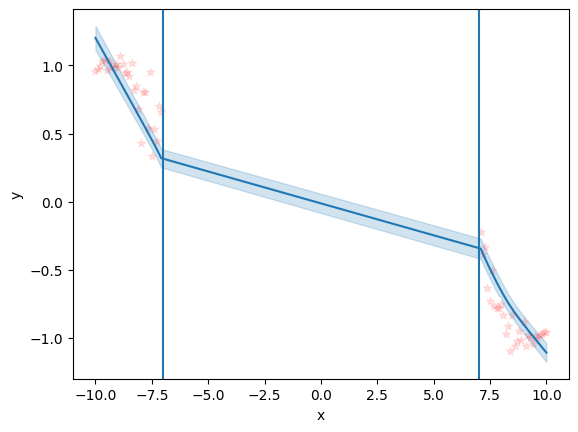

Epoch 149 | batch train loss: 0.2936024069786072 | test loss: 0.2286277711391449


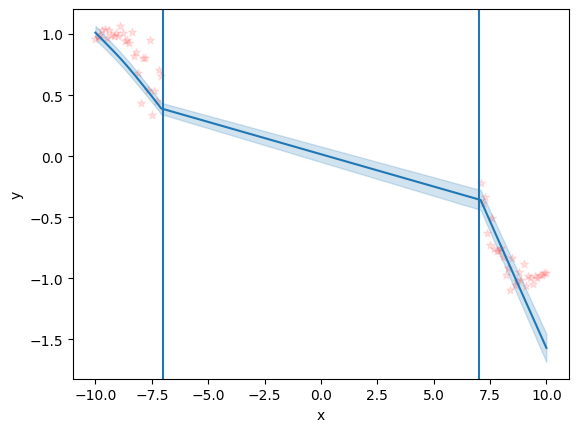

Epoch 149 | batch train loss: 0.19877979159355164 | test loss: 0.24798203259706497


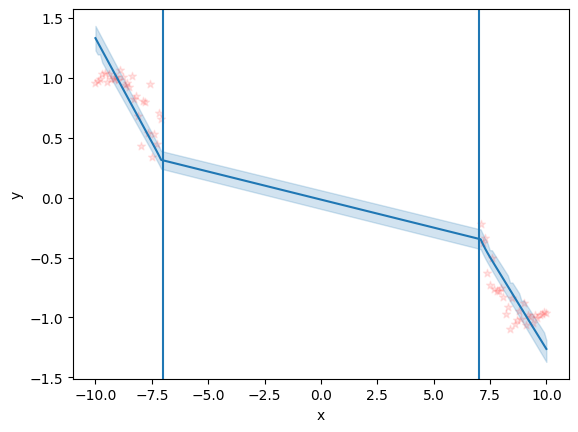

Epoch 149 | batch train loss: 0.18904413282871246 | test loss: 0.24259309843182564


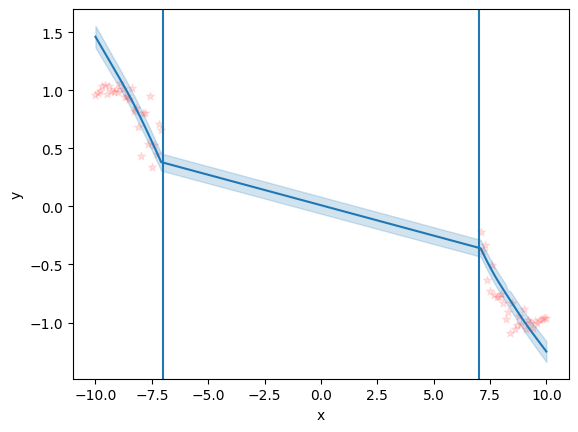

Epoch 149 | batch train loss: 0.18321289122104645 | test loss: 0.2512865662574768


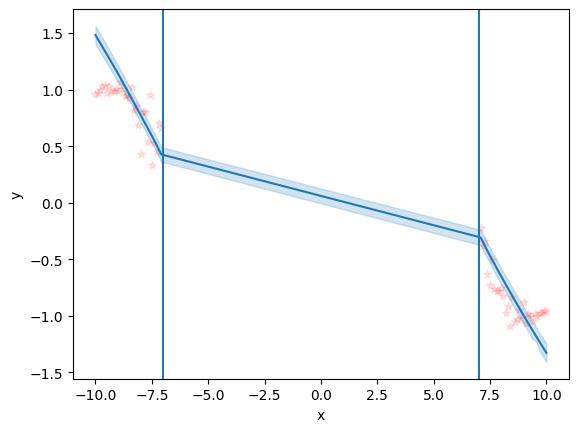

Epoch 149 | batch train loss: 0.17460297048091888 | test loss: 0.24025076255202293


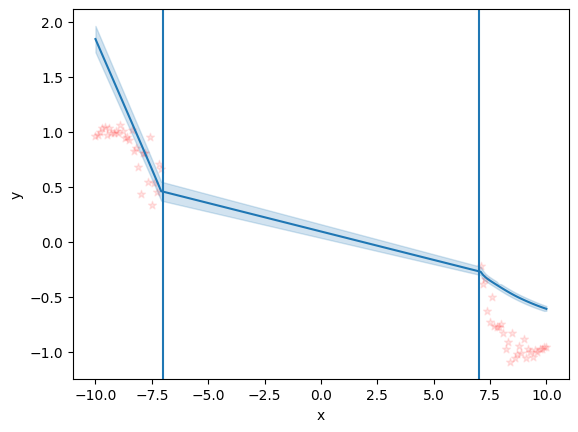

Epoch 149 | batch train loss: 0.17964255809783936 | test loss: 0.35311857610940933


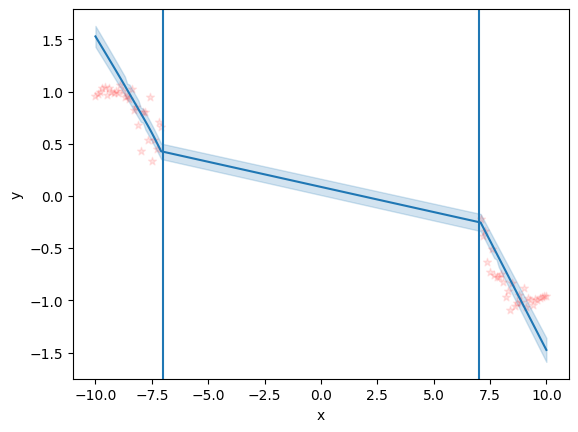

Epoch 149 | batch train loss: 0.19827714562416077 | test loss: 0.2567567937076092


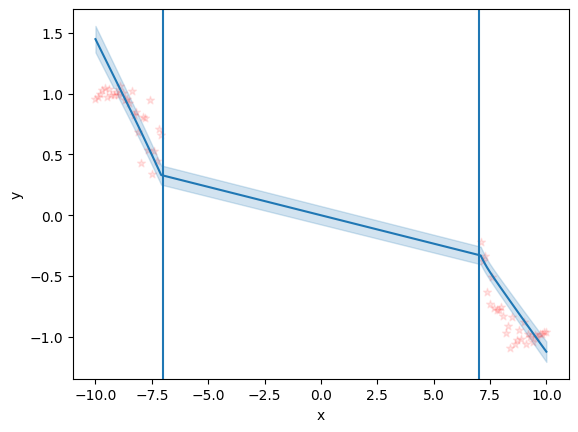

Epoch 149 | batch train loss: 0.1850115954875946 | test loss: 0.2546656019985676


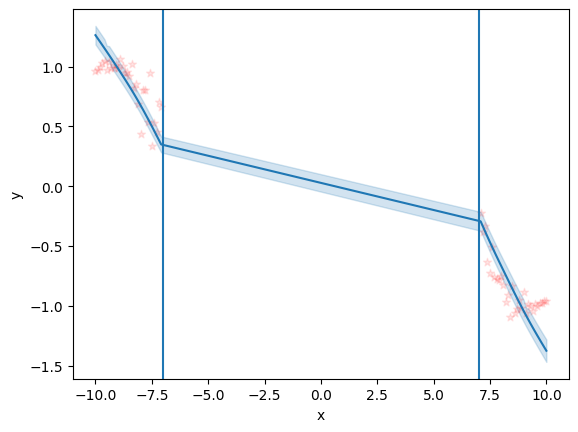

Epoch 149 | batch train loss: 0.1849832981824875 | test loss: 0.24087613075971603


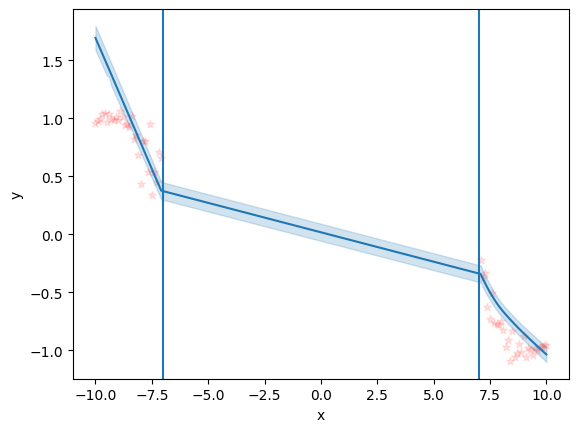

Epoch 149 | batch train loss: 0.2023075819015503 | test loss: 0.28551284223794937


In [19]:
train_losses_oodd=[]
test_losses_oodd=[]

for i in range(10):
  tr_loss,test_loss = MLE_bnn_oodd()
  train_losses_oodd.append(tr_loss)
  test_losses_oodd.append(test_loss)


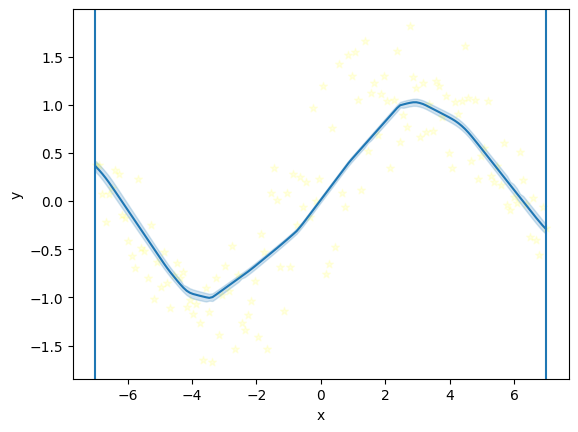

Epoch 149 | batch train loss: 0.19797706604003906 | test loss: 0.392708463801278


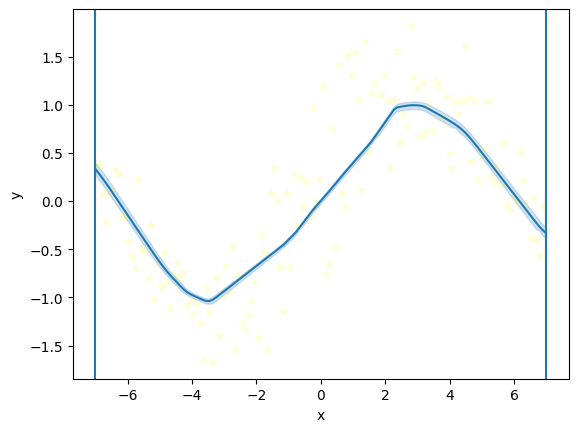

Epoch 149 | batch train loss: 0.1715458482503891 | test loss: 0.3853226767645942


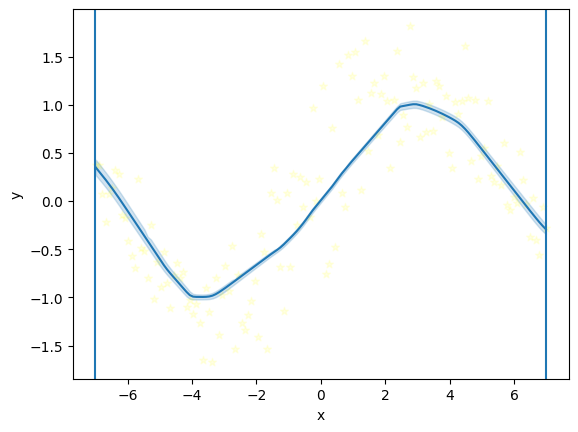

Epoch 149 | batch train loss: 0.19014747440814972 | test loss: 0.3885907729466756


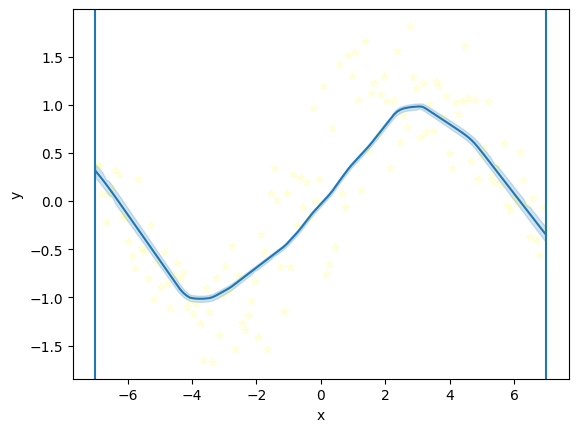

Epoch 149 | batch train loss: 0.21262308955192566 | test loss: 0.39013179805543685


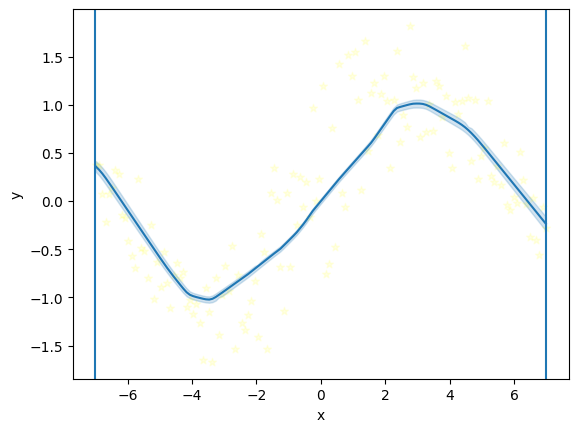

Epoch 149 | batch train loss: 0.17657409608364105 | test loss: 0.40095751815372044


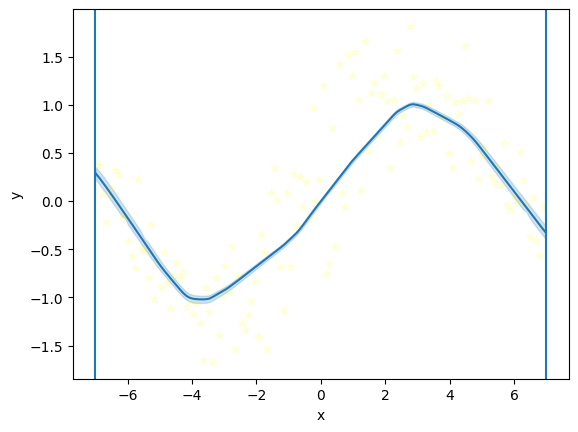

Epoch 149 | batch train loss: 0.17055505514144897 | test loss: 0.39296697907977635


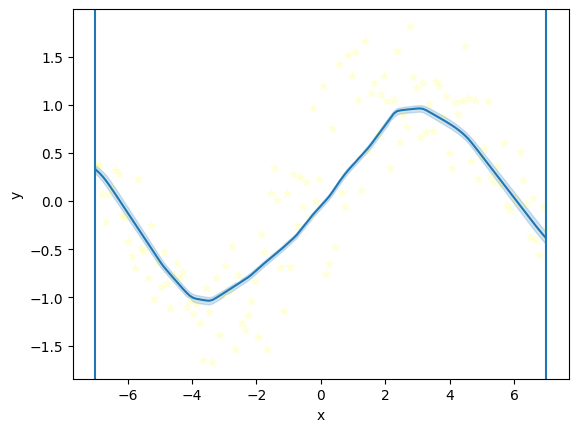

Epoch 149 | batch train loss: 0.15414264798164368 | test loss: 0.3928411735428704


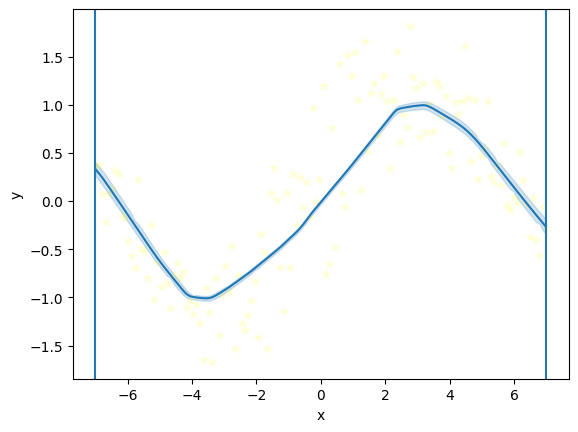

Epoch 149 | batch train loss: 0.23176494240760803 | test loss: 0.40523143609364826


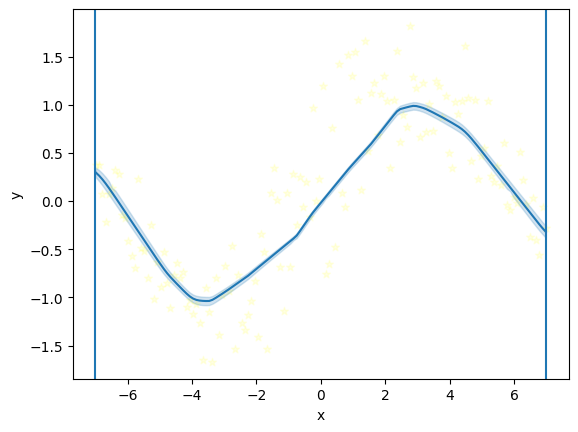

Epoch 149 | batch train loss: 0.1917458176612854 | test loss: 0.3926851550738017


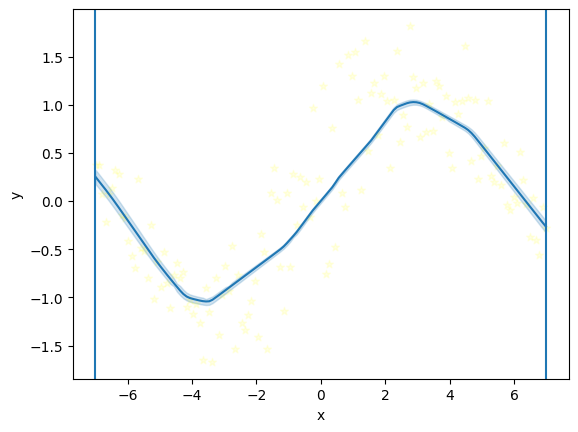

Epoch 149 | batch train loss: 0.1756715476512909 | test loss: 0.38744726445939803


In [20]:
train_losses_idd=[]
test_losses_idd=[]

for i in range(10):
  tr_loss,test_loss = MLE_bnn_idd()
  train_losses_idd.append(tr_loss)
  test_losses_idd.append(test_loss)


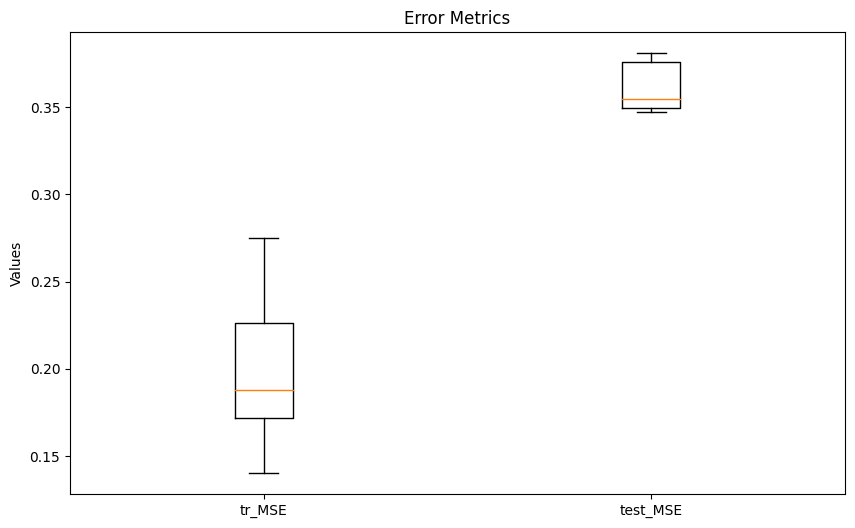

In [21]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= [tensor.item() for tensor in train_losses]
test_loss_values=test_losses

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values]
box_labels = ['tr_MSE', 'test_MSE']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metrics')

# Show the plot
plt.show()


In [22]:

# mean_gaus_train_loss = np.mean(tr_loss_values)
# std_dev_gaus_train_loss = np.std(tr_loss_values)

# mean_gaus_test_loss = np.mean(test_loss_values)
# std_dev_gaus_test_loss = np.std(test_loss_values)

mean_mse_train = np.mean(tr_loss_values)
std_dev_mse_train = np.std(tr_loss_values)

mean_mse_test = np.mean(test_loss_values)
std_dev_mse_test = np.std(test_loss_values)

# print('Mean of Gausiann Training Loss of 10 runs ', mean_gaus_train_loss)
# print('Standard Deviation of Gausiann Training Loss of 10 runs ' , std_dev_gaus_train_loss )

# print('Mean of Gausiann Testing Loss of 10 runs ',mean_gaus_test_loss )
# print('Standard Deviation of Gausiann Testing Loss of 10 runs ',std_dev_gaus_test_loss)

print('Mean of MSE Training of 10 runs ',mean_mse_train)
print('Standard Deviation of MSE Training of 10 runs ' , std_dev_mse_train)

print('Mean of MSE Testing of 10 runs ',mean_mse_test )
print('Standard Deviation of MSE Testing of 10 runs ', std_dev_mse_test)

Mean of MSE Training of 10 runs  0.19702922254800798
Standard Deviation of MSE Training of 10 runs  0.03917610523010609
Mean of MSE Testing of 10 runs  0.361141290802222
Standard Deviation of MSE Testing of 10 runs  0.013522720792703355


In [23]:
# Create a DataFrame from the lists
data = {
    'Training MSE': tr_loss_values,
    'Testing MSE': test_loss_values,
}

num_columns = len(data)

column_names = ['Training MSE','Testing MSE']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)
df.to_csv('results_bnn.csv', index=True)

    Training MSE  Testing MSE
1       0.186580     0.347460
2       0.140212     0.378286
3       0.171938     0.356821
4       0.193271     0.351576
5       0.171652     0.368837
6       0.189129     0.348639
7       0.237311     0.380806
8       0.240290     0.351854
9       0.164659     0.379954
10      0.275249     0.347179


In [24]:
print(test_loss_values)

[0.3474599581498366, 0.3782861324457022, 0.3568211106153635, 0.35157581246816194, 0.36883727403787464, 0.3486392773114718, 0.38080639334825367, 0.35185365264232343, 0.37995388874640834, 0.3471794082568242]
